In [3]:
# # take videos and convert to image frame to frame
# import cv2 as cv
# import numpy as np
# import os

# video_folder = "E:/Drone/"

# for video_file in os.listdir(video_folder):
#     if video_file.endswith(".mp4"):
#         video_path = os.path.join(video_folder, video_file)
#         cap = cv.VideoCapture(video_path)
#         output_folder = os.path.join(video_folder, "output_frames")
#         os.makedirs(output_folder, exist_ok=True)
#         frame_count = 0
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break

#             # save only every 20th frame
#             if frame_count % 20 == 0:
#                 frame_filename = os.path.join(
#                     output_folder,
#                     f"{os.path.splitext(video_file)[0]}_frame_{frame_count:04d}.png"
#                 )
#                 cv.imwrite(frame_filename, frame)

#             frame_count += 1
# cap.release()
# cv.destroyAllWindows()

####################################################################### DONE #######################################################################

(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

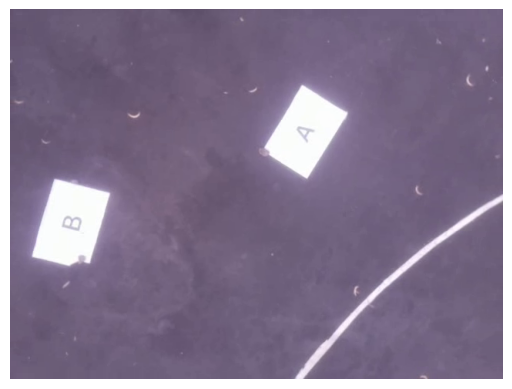

In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# test image for processing
image_path = "output_frames/recording_20250827_171942_frame_0380.png"

image = cv.imread(image_path)
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')


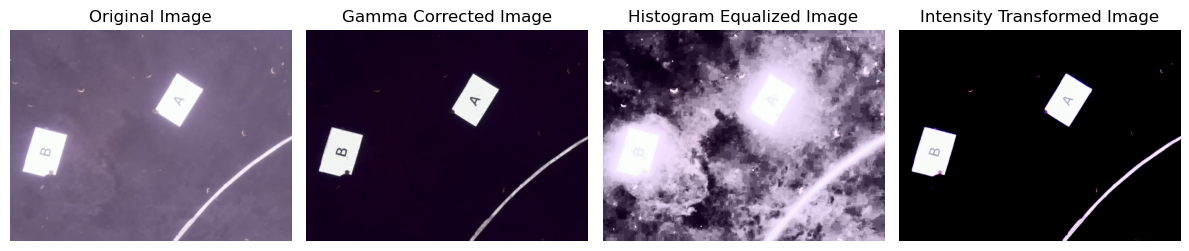

In [ ]:
# gamma correction
def gamma_correction(image):
    gamma = 0.2
    image_lab = cv.cvtColor(image, cv.COLOR_BGR2Lab)
    G = np.array([((i / 255) ** (1 / gamma)) * 255 for i in range(256)]).astype("uint8")
    image_lab[:, :, 0] = cv.LUT(image_lab[:, :, 0], G)
    image_corrected = cv.cvtColor(image_lab, cv.COLOR_Lab2BGR)
    return image_corrected

#Histogram Equalization
def hist_equalizer(frame):
    img_yuv = cv.cvtColor(frame, cv.COLOR_BGR2YUV)
    img_yuv[:, :, 0] = cv.equalizeHist(img_yuv[:, :, 0])
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
    
    return img_output

# Intensity Transformation
def intensity_tf(frame):
    # Segment 1: input 0–59 → output 0–0
    t1 = np.linspace(0, 0, 180)
 
    # Segment 2: input 60–179 → output 60–180
    t2 = np.linspace(150, 180, 30)

    # Segment 3: input 180–255 → output 200–255
    t3 = np.linspace(200, 255,46 )  # 256 -
    t = np.concatenate((t1,t2,t3), axis=0).astype('uint8')
    transformed_frame = t[frame]
    
    
    return transformed_frame



# plot results
fig, ax = plt.subplots(1, 4, figsize=(12, 6))
ax[0].imshow(image_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')
image_gamma_corrected = gamma_correction(image)
image_gamma_corrected_rgb = cv.cvtColor(image_gamma_corrected, cv.COLOR_BGR2RGB)
ax[1].imshow(image_gamma_corrected_rgb)
ax[1].set_title('Gamma Corrected Image')
ax[1].axis('off')
image_hist_eq = hist_equalizer(image)
image_hist_eq_rgb = cv.cvtColor(image_hist_eq, cv.COLOR_BGR2RGB)
ax[2].imshow(image_hist_eq_rgb)
ax[2].set_title('Histogram Equalized Image')
ax[2].axis('off')
image_intensity_tf = intensity_tf(image)
image_intensity_tf_rgb = cv.cvtColor(image_intensity_tf, cv.COLOR_BGR2RGB)
ax[3].imshow(image_intensity_tf_rgb)
ax[3].set_title('Intensity Transformed Image')
ax[3].axis('off')
plt.tight_layout()
plt.show()


(np.float64(-0.5), np.float64(639.5), np.float64(479.5), np.float64(-0.5))

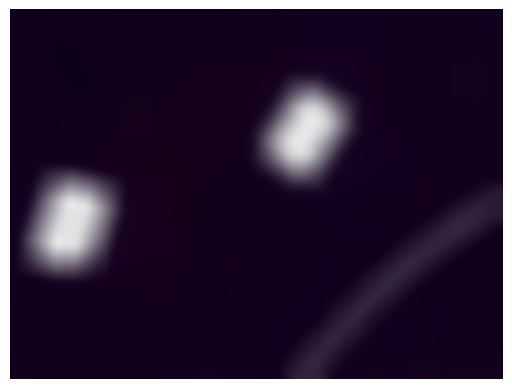

In [6]:
# averge filter
def average_filter(image):
    kernel_size = 50
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)
    filtered_image = cv.filter2D(image, -1, kernel)
    return filtered_image
gamma_image = gamma_correction(image)
image_filtered = average_filter(gamma_image)
image_filtered_rgb = cv.cvtColor(image_filtered, cv.COLOR_BGR2RGB)
plt.imshow(image_filtered_rgb)
plt.axis('off')

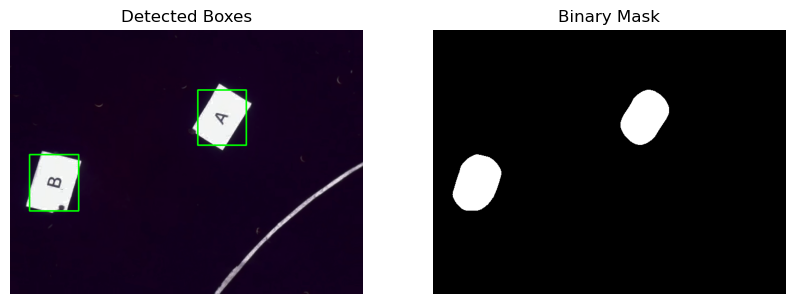

In [7]:
# open cv box detector by connected component
gamma_image = gamma_correction(image)
# Grayscale
img_gray = cv.cvtColor(image_filtered, cv.COLOR_BGR2GRAY)

# Threshold instead of Canny (faster if clean)
_, binary = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
# Connected components

# num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(binary)

# image_with_boxes = gamma_image.copy()
# for i in range(1, num_labels):  # skip background
#     x, y, w, h, area = stats[i]
#     if area > 100 and 0.04< area/(w*h) < 1:
#         cv.rectangle(image_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 2)
# # Show results

contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
image_with_boxes = gamma_image.copy()
for contour in contours:
    if cv.contourArea(contour) > 100:  # filter small shapes
        x, y, w, h = cv.boundingRect(contour)
        if 0.04 < cv.contourArea(contour) / (w * h) < 1:
            cv.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(image_with_boxes, cv.COLOR_BGR2RGB))
plt.title('Detected Boxes')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(binary, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')
plt.show()

In [ ]:
# test above functions on video
video_path = "recording_20250827_174911.mp4"
cap = cv.VideoCapture(video_path)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gamma_image = gamma_correction(frame)
    # Grayscale
    filtered_img = average_filter(gamma_image)
    img_gray = cv.cvtColor(filtered_img, cv.COLOR_BGR2GRAY)

    # Threshold instead of Canny (faster if clean)
    _, binary = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
    # Connected components
    contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes
    image_with_boxes = gamma_image.copy()
    for contour in contours:
        if cv.contourArea(contour) > 100:  # filter small shapes
            x, y, w, h = cv.boundingRect(contour)
            if 0.4 < cv.contourArea(contour) / (w * h) < 1:
                cv.rectangle(image_with_boxes, (x-15, y-15), (x + w+15, y + h+15), (0, 255, 0), 2)

    # Show results
    combined_image = np.hstack((image_with_boxes, frame))
    cv.imshow('Detected Boxes and Binary Mask', combined_image)
    
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


: 

In [ ]:
#save cropped dataset
import os
import cv2 as cv
import numpy as np

output_dir = 'cropped_dataset'

for image in os.listdir("output_frames"):
    if image.endswith(".png"):
        image_path = os.path.join("output_frames", image)
        img = cv.imread(image_path)

        gamma_image = gamma_correction(img)
        filtered_img = average_filter(gamma_image)
        img_gray = cv.cvtColor(filtered_img, cv.COLOR_BGR2GRAY)
        _, binary = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY)
        contours, _ = cv.findContours(binary, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv.contourArea(contour) > 100:  # filter small shapes
                x, y, w, h = cv.boundingRect(contour)
                if 0.4 < cv.contourArea(contour) / (w * h) < 1:
                    cropped = img[y:y+h, x:x+w]
                    if cropped.size == 0:
                        continue
                    os.makedirs(output_dir, exist_ok=True)
                    crop_filename = os.path.join(output_dir, f"{os.path.splitext(image)[0]}_crop_{x}_{y}.png")
                    cv.imwrite(crop_filename, cropped)


In [ ]:
import torch
import cv2 as cv
import numpy as np
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(cv.__version__)
print(np.__version__)

2.5.1
True
12.1
4.10.0
2.0.1
